<a href="https://colab.research.google.com/github/CadeHarger/portfolio/blob/main/Personal_Projects/Stock_Market_Round_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Setup Dependencies
!pip install tensorflow-probability

from IPython import display

import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import random
import time

In [ ]:
#@title Load and Format Dataset
testSize = 300 #@param{type: 'integer'}
valSize = 25 #@param{type: 'integer'}
aToK = pd.read_csv("StockDataset A-K.csv", low_memory=False)
kToZ = pd.read_csv("StockDataset K-Z.csv", low_memory=False)
preTickers = (list(aToK.columns) + list(kToZ.columns))[:-1]

a = np.swapaxes(aToK.to_numpy(), 0, 1)
z = np.swapaxes(kToZ.to_numpy(), 0, 1)
z = np.delete(z, -1, axis=1)

raw = np.delete(np.append(a, z, axis=0), 0, 1)
dates = []
sequences = []
invalid = []
tickers = []
for x in range(0, len(raw) - 1, 2):
  index = 0
  while index < len(raw[0]) and type(raw[x][index]) == type('s'):
    index += 1
  if index == 0 or index != len(raw[0]):
    invalid.append(int(x / 2))
  dates.append(raw[x][:index])
  sequences.append(raw[x + 1][:index])
  tickers.append(preTickers[x])
for x in range(len(invalid) - 1, -1, -1):
  del dates[invalid[x]]
  del sequences[invalid[x]]
  del tickers[invalid[x]]

tmp = sequences[220:]
sequences[220:] = dates[220:]
dates[220:] = tmp
sequences = np.array(sequences).astype('float32')

data = np.expand_dims(np.swapaxes(sequences, 0, 1), -1)
train = data[:-1 * testSize]
test = data[-1 * testSize:]
train = np.swapaxes(train, 0, 1)
test = np.swapaxes(test, 0, 1)

for x in range(len(train)):
  train[x] = (train[x] - min(train[x]))
  train[x] /= max(train[x])

validation = train[-1 * valSize:]
train = train[:-1 * valSize]

print('Train Shape:      ', train.shape)
print('Validation Shape: ', validation.shape)
print('Test Shape:       ', test.shape)

Train Shape:       (400, 2634, 1)
Validation Shape:  (25, 2634, 1)
Test Shape:        (425, 300, 1)


In [ ]:
#@title Define the Model(s)
class VAE(tf.keras.Model):
  def __init__(self, latentDims):
    super(VAE, self).__init__()
    self.latentDims = latentDims
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(2634, 1)),
      tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, activation='relu'),
      tf.keras.layers.Conv1D(filters=64, kernel_size=4, strides=2, activation='relu'),
      tf.keras.layers.MaxPool1D(pool_size=2),
      tf.keras.layers.Conv1D(filters=96, kernel_size=3, strides=2, activation='relu'),
      tf.keras.layers.Conv1D(filters=96, kernel_size=3, strides=2, activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(latentDims + latentDims)
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(latentDims,)),
      tf.keras.layers.Dense(328, activation=tf.nn.relu),
      tf.keras.layers.Reshape((328, 1)),
      tf.keras.layers.Conv1DTranspose(filters=96, kernel_size=3, strides=2, activation='relu'),
      tf.keras.layers.Conv1DTranspose(filters=64, kernel_size=3, strides=2, activation='relu'),
      tf.keras.layers.Conv1DTranspose(filters=32, kernel_size=4, strides=2, activation='relu'),
      tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=3, strides=1),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(2634, use_bias=False),
      tf.keras.layers.Reshape((2634, 1))
    ])

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latentDims))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

optimizer = tf.keras.optimizers.Adam(2e-5)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mse = tf.keras.losses.MeanSquaredError()
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  err = -mse(y_true=x, y_pred=x_logit)
  #cross_ent = -tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  #logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
  #logpz = log_normal_pdf(z, 0., 0.)
  #logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(err)# + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
#@title Train the Model
model = VAE(latentDims=200)
model.encoder.summary()
epochs = 500
batchSize = 25

losses = []
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for x in range(int(len(train) / batchSize)):
    train_step(model, train[x:x + batchSize], optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  loss(compute_loss(model, validation))
  elbo = loss.result()
  losses.append(elbo)
  #display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))

plt.plot(losses)

tf.Tensor(2.9761799e-05, shape=(), dtype=float32)
1.026016
1.0


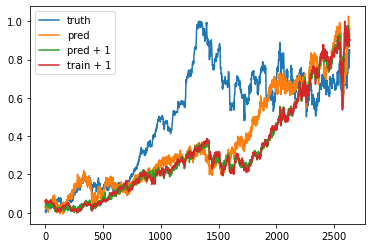

In [ ]:
#@title Test the VAE
example =  2#@param{type:'integer'}
plt.plot(train[example], label='truth')
mean, logvar = model.encode(np.expand_dims(train[0], 0))
result = model.decode(model.reparameterize(mean, logvar))
plt.plot(result[0], label='pred')


mean, logvar = model.encode(np.expand_dims(train[example + 1], 0))
resultant = model.decode(model.reparameterize(mean, logvar))
plt.plot(resultant[0], label='pred + 1')
plt.plot(train[example + 1], label='train + 1')
plt.legend()

print(compute_loss(model, np.expand_dims(train[example], 0)))
print(np.max(result[0]))
print(np.max(train[example]))

In [ ]:
# Beginning of abandonded attempt to use reinforcement learning

class StockUpGame:
  def __init__(self, trainData, histCount):
    self.trainData = trainData
    self.histCount = histCount
    self.currentGraph = trainData[0]
    self.dayNo = histCount
    self.graphNo = 0
    self.cash = 500
    self.buyPrice = None
    self.isLong = None
    self.model = 0

  def buy(self):
    self.isLong = True
    self.buyPrice = self.currentGraph[self.dayNo]

  def sell(self):
    self.isLong = False
    self.buyPrice = self.currentGraph[self.dayNo]

  def end(self):
    self.isLong = None
    self.buyPrice = None

  def advance(self):
    self.dayNo += 1
    if self.dayNo == len(trainData[0]):
      self.end()
      self.dayNo = self.histCount
      self.graphNo += 1
      self.currentGraph = self.trainData[self.graphNo]
    else:
      self.getAIDecision(self.currentGraph[self.dayNo - self.histCount:self.dayNo + 1])
      if self.buyPrice is not None:
        if self.isLong:
          self.cash += self.cash * (self.currentGraph[self.dayNo] - self.buyPrice) / self.buyPrice
        else:
          self.cash += self.cash * (self.buyPrice - self.currentGraph[self.dayNo]) / self.buyPrice

  def getAIDecision(self, inputs):
    # need the graph, isLong, and the buyPrice
    # Perhaps forcefully decrease the chance of holding the longer a stock is held to discourage the
    # ai from just holding forever for an average gain. Also forcefully selling is possible, but a
    # daysHeld input might need to be appended.
    #
    # OPTIONS:
    # Network that outputs a buy or sell, and a number of days (no position holding aspect)
    #   Inputs: Graph   Outputs: Softmax(2), number of days to hold
    # One network for buying/selling/waiting decisions, another for holding or ending
    #   Inputs1: Graph    Inputs2: Graph, buyPrice    Outputs : Softmax(3)   Outputs2: Softmax(2)
    # One network that buys/sells/waits/ends with invalid options masked out
    #   Inputs: Graph, buyPrice, isLong   Outputs: Softmax(4)
    # Same as above but with buyPrice and isLong omitted as inputs
    #
    # Try: Dense, conv1d, transformer, lstm, Hybrid with dense connecting outputs







SyntaxError: ignored